# OPTIVER - TRADING AT THE CLOSE

## Import Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Insert Data + Read Data

In [3]:
df_train = pd.read_csv('train.csv')
df_train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [4]:
df_train = df_train[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df_train.head()

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,1,0,0,-5.519986
2,2,0,0,-8.389950
3,3,0,0,-4.010200
4,4,0,0,-7.349849


## Target before Training

<AxesSubplot:>

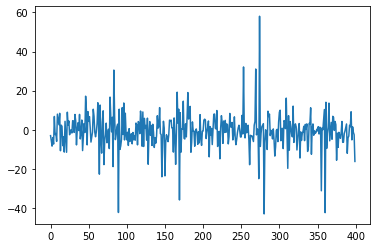

In [5]:
df_train.head(400)['target'].plot()

## Configuration Parameters

In [6]:
SEED = 42

N_LAGS = 55 # number of time lags used in the time series analysis.

BATCH_SIZE = 32
BUFFER_SIZE = 100000 # used for shuffling the data during training
EPOCHS = 100
PATIENCE = 25 # used as a parameter in early stopping
LEARNING_RATE = 1e-4

SPLIT_DAY = 390 # day on which the dataset is split into training and validation sets. 

# parameters define the size of the dataset, specifying the number of stocks, dates, and seconds
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

RUN_TRAINING = True # A boolean flag indicating whether to run the training process. If set to True, the model training code will be executed.

## Creating Index Combinations

In [7]:
# creating a lists of unique identifiers for stocks, dates, and seconds

all_stock_ids = range(N_STOCKS) # generates stock IDs
all_date_ids = range(N_DATES) # generates date IDs
all_seconds = [i * 10 for i in range(N_SECONDS)] # generates seconds in increments of 10

## Creating Multindex

In [8]:
# generateing all possible combinations of stock IDs, date IDs, and seconds, creating a hierarchical index

multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

## Update DataFrame

In [9]:
df_full = df_train.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index) # reindex method is used to align the DataFrame with the new MultiIndex created 

missing_values_count = df_full.isnull().sum()
print(missing_values_count)

target    53108
dtype: int64


## Fixing Null values

In [10]:
df_full = df_full.fillna(0) # Filling with 0
df_full = df_full.reset_index()

missing_values_count = df_full.isnull().sum()
print(missing_values_count)


stock_id             0
date_id              0
seconds_in_bucket    0
target               0
dtype: int64


## Assertion Check

In [11]:
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS) # ensures that the resulting DataFrame has the expected number of rows, which should be the product of the specified numbers of stocks, dates, and seconds
df_full

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


## Handling missing values in the Data

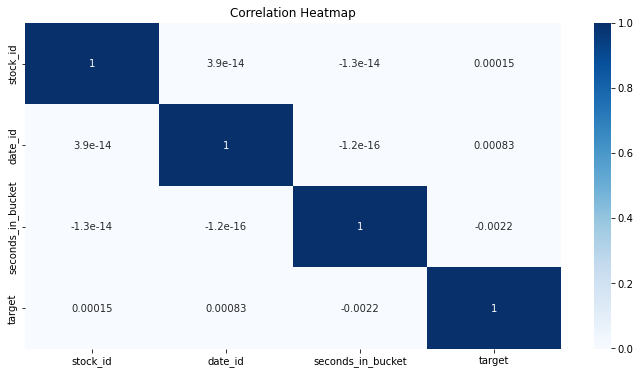

In [12]:
selected_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
selected_data = df_full[selected_columns]

plt.figure(figsize=(12,6))

sns.heatmap(selected_data.corr(), cmap="Blues", annot=True) #Dropping the first column bc it is date 
plt.title('Correlation Heatmap')
plt.show()

## Training the dataset

In [13]:
# Select a percentage of the data to use
percentage_to_use = 1

sampled_data = df_full.sample(frac=percentage_to_use, random_state=31)

y = sampled_data['target'].values
x = sampled_data[['stock_id', 'date_id', 'seconds_in_bucket']].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = SEED) ## The 0.2 is 20% testing

## Creating Random Forest Regression Model

In [17]:
seed = 221
n_dec_trees = 50

regressor = RandomForestRegressor(n_estimators=n_dec_trees, random_state=seed)

# fit linear regression

model = regressor.fit(x_train, y_train)

# Use model to make predictions

y_train_pred = regressor.predict(x_train)

# predicting results
print("Predicted results: ",y_train_pred)

Predicted results:  [ 1.88630821 -0.07379056 -6.65142536 ... -0.86526871  4.27641888
 10.27853482]


In [18]:
dframe = pd.DataFrame({'Actual':y_train.flatten(), 'Predicted':y_train_pred.flatten()}) ## so we are able to see the data better presented below
dframe.head(25)

,Actual,Predicted
0,-1.019835,1.886308
1,1.610518,-0.073791
2,-10.510087,-6.651425
3,1.080036,0.194347
4,-1.670122,-2.403307
5,-3.179908,-3.065217
6,-3.629923,-3.714407
7,1.200438,2.311528
8,-4.889965,-4.402339
9,-1.299977,-1.310563


In [19]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

Mean Absolute Error: 1.7180215657814946
Mean Squared Error: 6.554552694932057
Root Mean Square Error: 2.560186066467056


## Presenting results with graphs

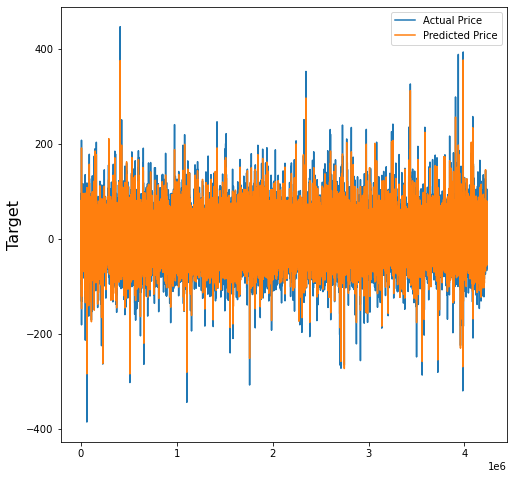

In [20]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<AxesSubplot:>

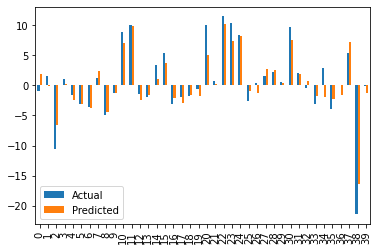

In [21]:
graph = dframe.head(40)
graph.plot(kind='bar')

## Grid Search with Cross-Validation

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Assuming y and x are already defined

param_grid = {
    'n_estimators' : [25, 50, 75]
}

regressor = RandomForestRegressor(random_state=seed)

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv = 3, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

best_n_estimators = grid_search.best_params_['n_estimators']

print('Best number of trees: ', best_n_estimators)

Best number of trees:  75


## Train Model with Best Hyperparameter

In [22]:
best_n_estimators = 75

final_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=seed)
final_model.fit(x_train, y_train)


,Actual,Predicted
0,-1.019835,1.886308
1,1.610518,-0.073791
2,-10.510087,-6.651425
3,1.080036,0.194347
4,-1.670122,-2.403307
5,-3.179908,-3.065217
6,-3.629923,-3.714407
7,1.200438,2.311528
8,-4.889965,-4.402339
9,-1.299977,-1.310563


## Make Predictions with Training Data

In [30]:
# Use model to make predictions
y_train_pred = regressor.predict(x_train)

# Create Data Frame with real Y and predicted Y
dframe = pd.DataFrame({'Actual':y_train.flatten(), 'Predicted':y_train_pred.flatten()}) ## so we are able to see the data better presented below
dframe.head(25)

,Actual,Predicted
0,-1.019835,1.886308
1,1.610518,-0.073791
2,-10.510087,-6.651425
3,1.080036,0.194347
4,-1.670122,-2.403307
5,-3.179908,-3.065217
6,-3.629923,-3.714407
7,1.200438,2.311528
8,-4.889965,-4.402339
9,-1.299977,-1.310563


## Calculate MAE, MSE and RMSE of Final Model Training

In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

Mean Absolute Error: 1.7180215657814946
Mean Squared Error: 6.554552694932057
Root Mean Square Error: 2.560186066467056


## Present Training Results With Graphs

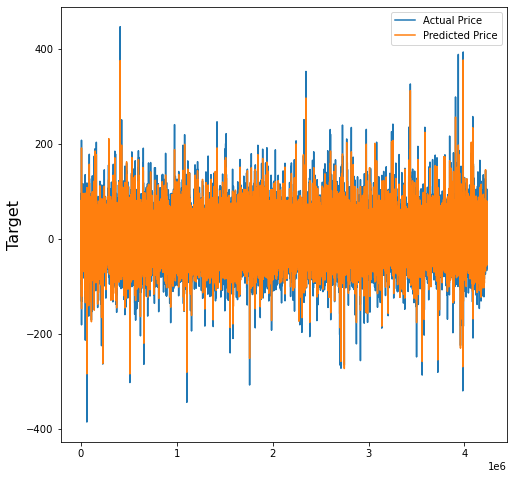

In [32]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

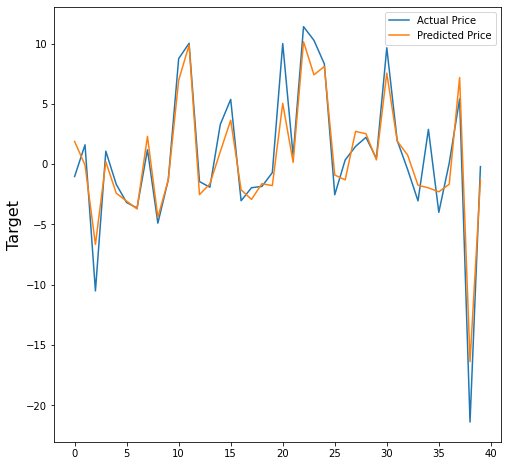

In [33]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe.head(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<AxesSubplot:>

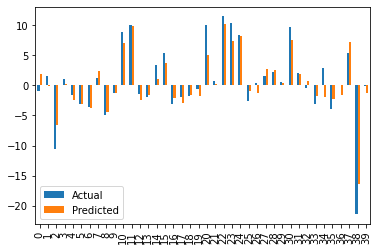

In [34]:
graph = dframe.head(40)
graph.plot(kind='bar')

## Test Model With Test Data

In [36]:
y_test_pred = regressor.predict(x_val)

# Create Data Frame with real Y and predicted Y
dframe = pd.DataFrame({'Actual':y_val.flatten(), 'Predicted':y_test_pred.flatten()}) ## so we are able to see the data better presented below
dframe.head(25)

,Actual,Predicted
0,5.279779,-3.260040
1,4.320145,0.140655
2,7.050037,-1.753140
3,11.789799,2.174663
4,-2.229810,8.184028
5,-5.009770,2.035189
6,0.779629,5.872727
7,2.219677,0.264430
8,-8.360147,-5.414808
9,-7.150173,-4.692173


## Calculate MAE, MSE and RMSE of Final Model Test

In [37]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_test_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_val, y_test_pred)))

Mean Absolute Error: 4.555462932798533
Mean Squared Error: 44.56641912956073
Root Mean Square Error: 6.675808500066545


## Present Test Results With Graphs

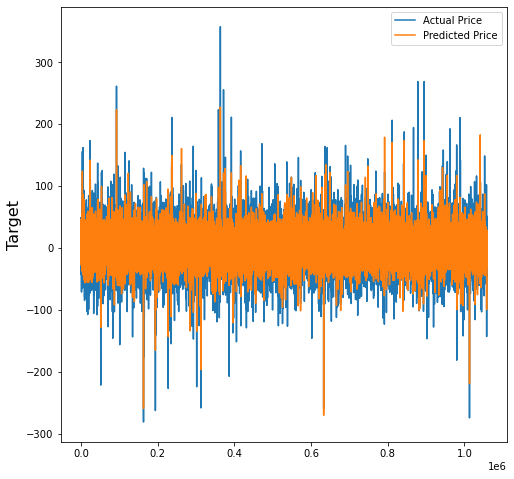

In [38]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

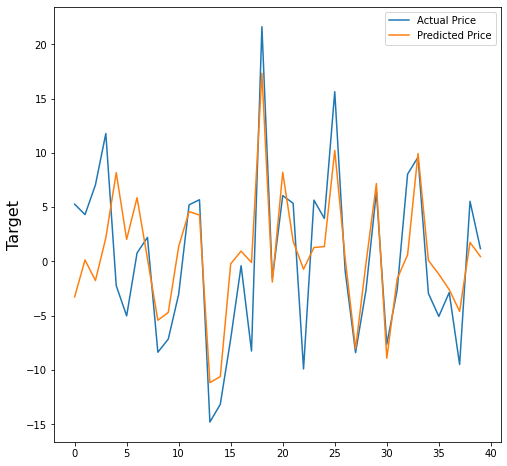

In [39]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe.head(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<AxesSubplot:>

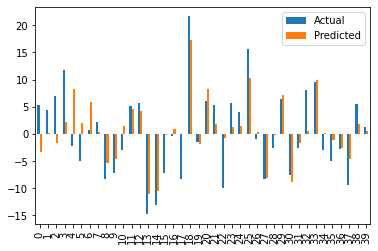

In [40]:
graph = dframe.head(40)
graph.plot(kind='bar')